In [1]:
!ls data

default-config-6369bbd7654895359e79db3f-data.csv
default-config-6369bbd7654895359e79db3f-data.csv.gz
og_train.csv
synth_confusion_matrix.jpg
synth_confusion_matrix.png
synth_roc.jpg
test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, precision_recall_curve, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.feature_selection import SelectFromModel

%matplotlib inline

In [3]:
synthetic = pd.read_csv("./data/default-config-6369bbd7654895359e79db3f-data.csv")
original = pd.read_csv("./data/og_train.csv")
synthetic.head(), original.head()

(   Unnamed: 0  39  State-gov   77516    Bachelors   13        Never-married  \
 0         897  38    Private  167873      Masters   14   Married-civ-spouse   
 1       26181  53    Private  287908      Masters   14            Separated   
 2       31600  35    Private  255690   Assoc-acdm   12              Widowed   
 3        5203  50    Private  498351      HS-grad    9            Separated   
 4       21833  41    Private  189975      Masters   14   Married-civ-spouse   
 
      Adm-clerical  Not-in-family   White     Male   2174   0    40  \
 0           Sales        Husband   White     Male      0   0  60.0   
 1    Adm-clerical      Unmarried   White   Female      0   0  45.0   
 2   Other-service      Unmarried   White   Female      0   0  40.0   
 3   Other-service      Unmarried   White   Female      0   0  30.0   
 4           Sales        Husband   White     Male      0   0  55.0   
 
     United-States   <=50K  
 0   United-States   <=50K  
 1   United-States   <=50K  
 2 

In [4]:
synthetic.info(), original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      20000 non-null  int64  
 1   39              20000 non-null  int64  
 2    State-gov      20000 non-null  object 
 3    77516          20000 non-null  int64  
 4    Bachelors      20000 non-null  object 
 5    13             20000 non-null  int64  
 6    Never-married  20000 non-null  object 
 7    Adm-clerical   20000 non-null  object 
 8    Not-in-family  20000 non-null  object 
 9    White          20000 non-null  object 
 10   Male           20000 non-null  object 
 11   2174           20000 non-null  int64  
 12   0              20000 non-null  int64  
 13   40             19999 non-null  float64
 14   United-States  20000 non-null  object 
 15   <=50K          20000 non-null  object 
dtypes: float64(1), int64(6), object(9)
memory usage: 2.4+ MB
<class 'pandas.core

(None, None)

In [5]:
synthetic.columns

Index(['Unnamed: 0', '39', ' State-gov', ' 77516', ' Bachelors', ' 13',
       ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male',
       ' 2174', ' 0', ' 40', ' United-States', ' <=50K'],
      dtype='object')

In [6]:
#uppercase X and Y followed by "s" for synthetic and "r" for real
#set targets for model training
Xs_train = synthetic.drop(columns=" <=50K")
Ys_train = pd.DataFrame(synthetic[" <=50K"])
Xr_train = original.drop(columns=" <=50K")
Yr_train = pd.DataFrame(original[" <=50K"])

In [7]:
synthetic.head()

,Unnamed: 0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,897,38,Private,167873,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,60.0,United-States,<=50K
1,26181,53,Private,287908,Masters,14,Separated,Adm-clerical,Unmarried,White,Female,0,0,45.0,United-States,<=50K
2,31600,35,Private,255690,Assoc-acdm,12,Widowed,Other-service,Unmarried,White,Female,0,0,40.0,United-States,<=50K
3,5203,50,Private,498351,HS-grad,9,Separated,Other-service,Unmarried,White,Female,0,0,30.0,Mexico,<=50K
4,21833,41,Private,189975,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,55.0,United-States,<=50K


In [8]:
#create primary pipeline elements

num_pipeline = Pipeline(steps=[("num_imp", SimpleImputer()),
                               ('ss', StandardScaler())])

cat_pipeline = Pipeline(steps=[("cat_imp", SimpleImputer(strategy="most_frequent")),
                               ("cat_ohe", OneHotEncoder(handle_unknown='ignore'))])

#column transformer
numeric_feature_names = ["39"," 13"," 40",' 2174',' 0']
categorical_feature_names = [" State-gov", " Bachelors", " Never-married", ' Adm-clerical', 
                             ' Not-in-family', ' White', ' Male', ' United-States']


col_tr = ColumnTransformer(transformers=[('num', num_pipeline, numeric_feature_names),
                                         ('cat', cat_pipeline, categorical_feature_names)], 
                           remainder='passthrough', sparse_threshold=0)


In [9]:
col_tr.fit_transform(Xs_train).shape

(20000, 106)

In [10]:
#simple decision trees
#syn = synthetic
syn_pipe = Pipeline(steps=[("ct", col_tr),
                           ("simp_dec_tree", DecisionTreeClassifier(max_depth=20, random_state=42))])
syn_pipe.fit(Xs_train, Ys_train)

#og = original
og_pipe = Pipeline(steps=[("ct", col_tr),
                           ("simp_dec_tree", DecisionTreeClassifier(max_depth=20, random_state=42))])
og_pipe.fit(Xr_train, Yr_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('num_imp',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['39', ' 13', ' 40', ' 2174',
                                                   ' 0']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_ohe',
                                                       

In [11]:
hex(id(syn_pipe)), hex(id(og_pipe))

('0x228869ea3a0', '0x228869d7490')

# Testing Models

In [12]:
!ls data

default-config-6369bbd7654895359e79db3f-data.csv
default-config-6369bbd7654895359e79db3f-data.csv.gz
og_train.csv
synth_confusion_matrix.jpg
synth_confusion_matrix.png
synth_roc.jpg
test.csv


In [13]:
#import test data
test = pd.read_csv("./data/test.csv")
test.head()

,Unnamed: 0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,14160,38,Private,680390,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,20,United-States,<=50K
1,27047,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
2,28867,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States,>50K
3,5667,51,Private,306108,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,>50K
4,7827,46,Private,124071,Masters,14,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,44,United-States,<=50K


In [14]:
#splitting test data and targets
x_test = test.drop(columns=" <=50K")
y_test = pd.DataFrame(test[" <=50K"])

x_test

,Unnamed: 0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
0,14160,38,Private,680390,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,20,United-States
1,27047,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
2,28867,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
3,5667,51,Private,306108,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States
4,7827,46,Private,124071,Masters,14,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,44,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8135,30175,43,Self-emp-not-inc,237670,Assoc-voc,11,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,25,United-States
8136,30745,30,Private,229772,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
8137,29400,60,Private,188650,5th-6th,3,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,?
8138,27264,25,?,230856,HS-grad,9,Never-married,?,Unmarried,Black,Female,0,0,40,United-States


In [15]:
#make predictions with each model
syn_pipe.fit(Xs_train, Ys_train)
syn_pred = syn_pipe.predict(x_test)

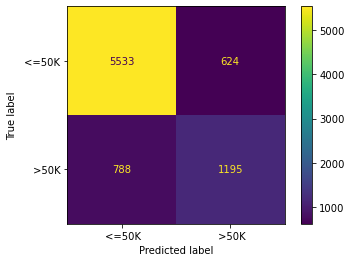

In [16]:
plot_confusion_matrix(syn_pipe, x_test, y_test);
plt.savefig("./data/synth_confusion_matrix.jpg")

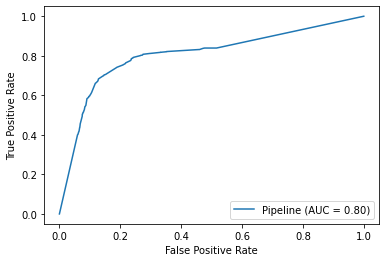

In [17]:
plot_roc_curve(syn_pipe, x_test, y_test);
plt.savefig("./data/synth_roc.jpg")

In [18]:
precision_recall_fscore_support(y_test, syn_pred)

(array([0.87533618, 0.65695437]),
 array([0.89865194, 0.60262229]),
 array([0.88684084, 0.62861652]),
 array([6157, 1983], dtype=int64))

In [19]:
accuracy_score(y_test, syn_pred)

0.8265356265356265

In [20]:
#make predictions for og model
og_pipe.fit(Xr_train, Yr_train)
og_pred = og_pipe.predict(x_test)

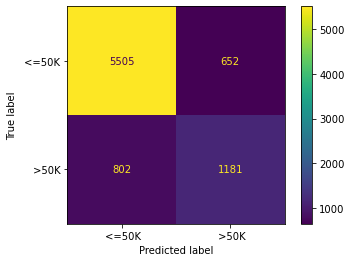

In [21]:
plot_confusion_matrix(og_pipe, x_test, y_test);
plt.savefig("./data/original_confusion_matrix.jpg")

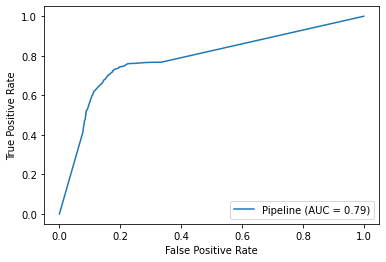

In [22]:
plot_roc_curve(og_pipe, x_test, y_test);
plt.savefig("./data/original_roc.jpg")

In [23]:
precision_recall_fscore_support(y_test, og_pred)

(array([0.8728397 , 0.64429896]),
 array([0.89410427, 0.59556228]),
 array([0.88334403, 0.61897275]),
 array([6157, 1983], dtype=int64))

In [24]:
accuracy_score(y_test, og_pred)

0.8213759213759214